In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)

In [2]:
def import_dataset(filename):
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "category",
                                      "day_of_week": "category",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # reorder categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    bank_mkt["month"] = bank_mkt["month"].cat.reorder_categories(["mar", "apr", "jun", "jul", "may", "aug", "sep", "oct", "nov", "dec"], ordered=True)
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].cat.reorder_categories(["mon", "tue", "wed", "thu", "fri"], ordered=True)
    return bank_mkt

In [3]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in train_test_split.split(bank_mkt.drop("y", axis=1), bank_mkt["y"]):
    bank_train_set = bank_mkt.loc[train_index].reset_index(drop=True)
    bank_test_set = bank_mkt.loc[test_index].reset_index(drop=True)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
def cat_encode(X, education=None, pdays=None):
    """Encode categorical data into numerical values.

    education: if education is "year", education column will be encoded into years of eductaion.
    pdays: if pdays is "cut", pdays column will be feature engineered and discretized.
    """
    X = X.copy()
    # If pdays is "cut", pdays column will be feature engineered and discretized.
    if pdays == "cut":
        X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
        X["pdays"] = pd.cut(X["pdays"], [0, 5, 10, 15, 30, 1000], labels=[1, 2, 3, 4, 5], include_lowest=True).astype("Int64")
    # Encode nominal and ordinal features
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3.
    month_map = {"mar": 3, 
                 "apr": 4, 
                 "jun": 5, 
                 "jul": 6, 
                 "may": 7, 
                 "aug": 8, 
                 "sep": 9, 
                 "oct": 10, 
                 "nov": 11, 
                 "dec": 12}
    X["month"] = X["month"].replace(month_map).astype("int")
    # Other categorical features will be coded as its order in pandas categorical index
    cat_features = ["job", "education", "marital", "contact", "day_of_week"]
    bool_features = ["default", "housing", "loan", "poutcome"]
    X[cat_features] = X[cat_features].apply(lambda x: x.cat.codes).astype("Int64")
    X[bool_features] = X[bool_features].astype("Int64")
    # Fill missing values as -1
    X = X.fillna(-1)
    # If education is "year", education column will be encoded into years of eductaion.
    if education == "year":
        education_map = { 0: 0, # illiterate
                          1: 4, # basic.4y
                          2: 6, # basic.6y
                          3: 9, # basic.9y
                          4: 12, # high.school
                          5: 15, # professional course
                          6: 16} # university
        X["education"] = X["education"].replace(education_map)
    return X

basic_encoder = FunctionTransformer(cat_encode)

cat_features = ["job", "marital", "education", "default", "housing", "loan", "month", "day_of_week", "pdays", "poutcome"]

basic_transformer = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first", sparse=False), cat_features)],
    remainder="passthrough")

basic_preprocessor = Pipeline([
    ("basic_encoder", basic_encoder),
    ("basic_transformer", basic_transformer),
    ("scaler", StandardScaler())
])

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

In [9]:
cat_features = ["job", "marital", "education", "default", "housing", "loan", "pdays", "poutcome"]

freq_nom_features = ["job", "marital", "default", "housing", "loan"]

freq_ord_features = ["education"]

one_hot_features = [i for i in cat_features if i not in freq_nom_features and i not in freq_ord_features]

cut_encoder = FunctionTransformer(cat_encode, kw_args={"pdays":"cut"})

freq_nom_imputer = Pipeline([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(drop="first", sparse=False))
])

freq_ord_imputer = Pipeline([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"))
])

freq_transformer = ColumnTransformer([
    ("freq_nom_imputer", freq_nom_imputer, freq_nom_features),
    ("freq_ord_imputer", freq_ord_imputer, freq_ord_features),
    ("one_hot_encoder", OneHotEncoder(drop="first", sparse=False), one_hot_features)],
    remainder="passthrough")

freq_preprocessor = Pipeline([
    ("cut_encoder", cut_encoder),
    ("freq_transformer", freq_transformer),
    ("scaler", StandardScaler())
])

In [10]:
ite_features = ["age", "job", "marital", "education", "default", "housing", "loan"]

one_hot_features = [1, 2, 11, 13] # ["job", "marital", "pdays", "poutcome"]

ite_imputer = Pipeline([
    ("ite_imputer", IterativeImputer(max_iter=100, missing_values=-1, initial_strategy="most_frequent", random_state=42)),
    ("ite_round", FunctionTransformer(np.round))
])

ite_transformer = ColumnTransformer([("ite_imputer", ite_imputer, ite_features)], remainder="passthrough")

one_hot_encoder = ColumnTransformer([("one_hot_encoder", OneHotEncoder(drop="first", sparse=False), one_hot_features)], remainder="passthrough")

ite_preprocessor = Pipeline([
    ("cut_encoder", cut_encoder),
    ("ite_transformer", ite_transformer),
    ("one_hot_encoder", one_hot_encoder),
    ("scaler", StandardScaler())
])

In [12]:
X_train = bank_train_set.drop(["duration", "y"], axis=1)
X_train_basic = basic_preprocessor.fit_transform(X_train)
X_train_freq = freq_preprocessor.fit_transform(X_train)
X_train_ite = ite_preprocessor.fit_transform(X_train)
y_train = bank_train_set["y"].astype("int").to_numpy()
X_test = bank_test_set.drop(["duration", "y"], axis=1)
X_test_basic = basic_preprocessor.fit_transform(X_test)
X_test_freq = freq_preprocessor.fit_transform(X_test)
X_test_ite = ite_preprocessor.fit_transform(X_test)
y_test = bank_test_set["y"].astype("int").to_numpy()

# Performance Metrics

In [22]:
import matplotlib.pyplot as plt
# cosmetic options for matplotlib
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlepad"] = 10.0
plt.rcParams["axes.titlelocation"] = "left"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
import seaborn as sns

In [21]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

## Confusion Matrics and Scores

The function `cross_val_predict` returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. It is not appropriate for measuring generalisation error but suited for comparing different models.

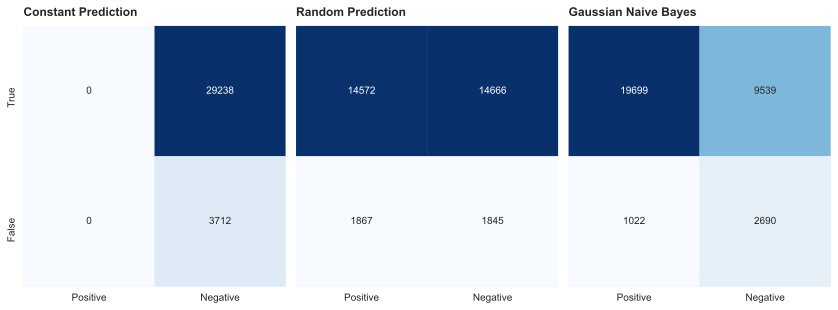

In [51]:
names = ["Constant Prediction", "Random Prediction", "Gaussian Naive Bayes"]
clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        GaussianNB()]
f, axs = plt.subplots(1, 3, figsize=(4.8*3+0.04*2, 4.8), sharey=True, gridspec_kw=dict(wspace=0.04, width_ratios=[1, 1, 1]))
for i, name, clf in zip([0,1,2], names, clfs):
    conf_mat = confusion_matrix(y_train, cross_val_predict(clf, X_train_freq, y_train, cv=10, n_jobs=-1))
    constant_ax = sns.heatmap(conf_mat, 
                              ax=axs[i], 
                              annot=True, 
                              fmt="", 
                              cmap=plt.cm.Blues, 
                              cbar=False, 
                              yticklabels=["True", "False"], 
                              xticklabels=["Positive", "Negative"]).set_title(name)

The performance metrics precision (PRE) and recall (REC) are related to those TP and TN rates

<AxesSubplot:>

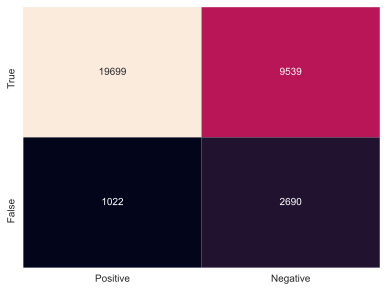

In [37]:
scoring = ["f1", "precision", "recall", "roc_auc"]
# Initialize Model
nb_model = GaussianNB()
logit_model = LogisticRegression(class_weight="balanced")
knn_model = KNeighborsClassifier(n_neighbors=5)
# Train model and get CV results 
nb_cv = cross_validate(nb_model, X_train, y_train, scoring=scoring, cv = 5)
logit_cv = cross_validate(logit_model, X_train, y_train, scoring=scoring, cv = 5)
knn_cv = cross_validate(knn_model, X_train, y_train, scoring=scoring, cv = 5)
# Calculate CV result mean
nb_result = pd.DataFrame(nb_cv).mean().rename("Naive Bayes")
logit_result = pd.DataFrame(logit_cv).mean().rename("Logistic Regression")
knn_result = pd.DataFrame(knn_cv).mean().rename("KNN")
# Store and output result
result = pd.concat([nb_result, logit_result, knn_result], axis=1)
result

/usr/local/Caskroom/miniconda/base/envs/analytics/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/analytics/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/Caskroom/miniconda/base/envs/analytics/lib/python3.8/site-packages/sklearn/naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "/usr/local/Caskroom/miniconda/base/envs/analytics/lib/python3.8/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/Caskroom/miniconda/base/envs/analytics/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/

,Naive Bayes,Logistic Regression,KNN
fit_time,0.005815,0.004253,0.004139
score_time,0.000000,0.000000,0.000000
test_f1,NaN,NaN,NaN
test_precision,NaN,NaN,NaN
test_recall,NaN,NaN,NaN
test_roc_auc,NaN,NaN,NaN


In [24]:
X_test = preprocessor.transform(bank_test_set.drop(["duration", "y"], axis=1))
y_test = bank_test_set["y"].astype("int").to_numpy()
# Initialize and fit Model

nb_model = GaussianNB().fit(X_train, y_train)
logit_model = LogisticRegression(class_weight="balanced").fit(X_train, y_train)
knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
# Predict and calculate score
dummy_predict = dummy_model.predict(X_test)
dummy_f1 = f1_score(y_test, dummy_predict)
dummy_precision = precision_score(y_test, dummy_predict)
dummy_recall = recall_score(y_test, dummy_predict)
dummy_roc_auc = roc_auc_score(y_test, dummy_predict)
nb_predict = nb_model.predict(X_test)
nb_f1 = f1_score(y_test, nb_predict)
nb_precision = precision_score(y_test, nb_predict)
nb_recall = recall_score(y_test, nb_predict)
nb_roc_auc = roc_auc_score(y_test, nb_predict)
logit_predict = logit_model.predict(X_test)
logit_f1 = f1_score(y_test, logit_predict)
logit_precision = precision_score(y_test, logit_predict)
logit_recall = recall_score(y_test, logit_predict)
logit_roc_auc = roc_auc_score(y_test, logit_predict)
knn_predict = knn_model.predict(X_test)
knn_f1 = f1_score(y_test, knn_predict)
knn_precision = precision_score(y_test, knn_predict)
knn_recall = recall_score(y_test, knn_predict)
knn_roc_auc = roc_auc_score(y_test, knn_predict)
# Store and output result
result = pd.DataFrame(data={"Dummy Classifier": [dummy_f1, dummy_precision, dummy_recall, dummy_roc_auc],
                            "Naive Bayes": [nb_f1, nb_precision, nb_recall, nb_roc_auc],
                            "Logistic Regression": [logit_f1, logit_precision, logit_recall, logit_roc_auc],
                            "KNN": [knn_f1, knn_precision, knn_recall, knn_roc_auc]},
                       index=["F1 Score", "Precision Score", "Recall Score", "ROC AUC Score"])
result

NameError: name 'preprocessor' is not defined